## Table of Contents:
* [Part 1: Project Intro](#part-1)
* [Part 2: Exploratory data analysis (EDA)](#part-2)
* [Part 3: Data Cleanup](part-3)
* [Part 4: Matrix Factorization](#part-4)
* [Part 5: Model Tuning](#part-5)
* [Part 6: Supervised Learning Model](#part-6)
* [Part 7: Summary](#part-7)

## Part 1: Project Intro <a class="anchor" id="part-1"></a>

This project will look at passenger data from the Titanic and attempt to predict which passengers survived.  Thie project is on Kaggle and can be found here - [Kaggle Titanic Project](https://www.kaggle.com/competitions/titanic/overview).

The project contains 3 files:
1. Training data that includes whether the passenger survive
2. Test data that does not include survival info
3. Sample solution data that simply predicts that all females survive and all males did not survive

## Part 2: Exploratory data analysis (EDA) <a class="anchor" id="part-2"></a>
Kaggle provides the following description of the values in the dataset.
**Variable: Definition, Key**
1. survival: Survival, 0 = No, 1 = Yes
2. pclass: Ticket class, 1 = 1st, 2 = 2nd, 3 = 3rd
3. sex: Sex	
4. Age: Age in years	
5. sibsp: # of siblings / spouses aboard the Titanic	
6. parch: # of parents / children aboard the Titanic	
7. ticket: Ticket number	
8. fare: Passenger fare	
9. cabin: Cabin number	
10. embarked: Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

To start, let's analyze the dataset we've been given to understand the overall data structure, type of data, outliers, etc.  During this EDA we'll be looking for characteristics of the data that may need to be fixed before we can create a learning model based on it.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

test_data = pd.read_csv('data/test.csv')
train_data = pd.read_csv('data/train.csv')
sample_solution_data = pd.read_csv('data/gender_submission.csv')

print ("TEST DATA:")
print (test_data.head())
print(test_data.info())

print ("TRAIN DATA:")
print (train_data.head())
print (train_data.info())

print ("SAMPLE SOLUTION:")
print (sample_solution_data.head())
print (sample_solution_data.info())

TEST DATA:
   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       -

/var/folders/4s/wp81fvbx7216w_7lbpf_jmx00000gn/T/ipykernel_3017/2064694755.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Based on the initial analysis above, I have noticed a few things:
1. The names are sometimes quite long, such as "Hirvonen, Mrs. Alexander (Helga E Lindqvist)".  It's unclear to me what the additional name in parentheses represents, so I'll have to dig into that.
2. The "Cabin" data appears to have many "Nan" values.  
3. The "Sex" data has values of "male" or "female" of type "object".  This may benefit from translating the datatype from "object" to a binary value for improved ability to use this data later.

Those are just a few observations.  Let's look at the data in more depth now.

In [2]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Now let's look at each individual value in more detail, starting with passenger ID.  I expect each passenger to have a unique ID, so let's confirm that suspicion.  

In [5]:
all_passenger_ids_are_unique = (len(train_data["PassengerId"]) == len(set(train_data["PassengerId"])))
print ("All passenger IDs are unique:", all_passenger_ids_are_unique)  
passenger_id_has_nans = np.isnan(train_data["PassengerId"]).any()
print ("Passenger ID data has nan values:", passenger_id_has_nans)

All passenger IDs are unique: True
Passenger ID data has nan values: False


In [7]:
survived_data_is_all_1_or_0 = all(val == 0 or val == 1 for val in train_data["Survived"])
print ("Survived data is all 1s or 0s:", survived_data_is_all_1_or_0)
survived_data_has_nans = np.isnan(train_data["Survived"]).any()
print ("Survived data has nan values:", survived_data_has_nans)

Survived data is all 1s or 0s: True
Survived data has nan values: False


Pclass data has nan values: False


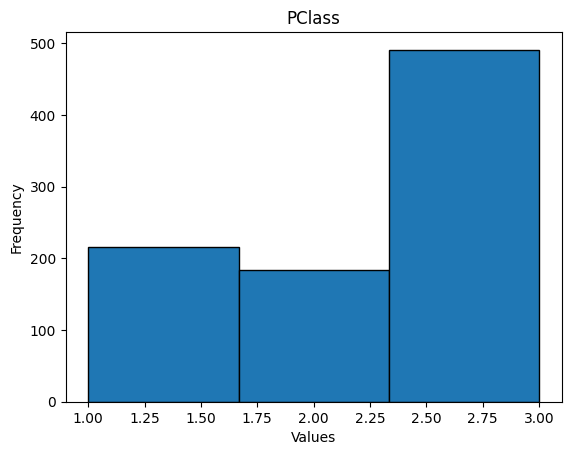

In [11]:
pclass_data_has_nans = np.isnan(train_data["Pclass"]).any()
print ("Pclass data has nan values:", pclass_data_has_nans)

plt.hist(train_data["Pclass"], bins=3, edgecolor='black')
plt.title('PClass')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

In [14]:
sex_data_is_all_male_or_female = all(val == 'male' or val == 'female' for val in train_data["Sex"])
print ("Sex data is all either male or female:", sex_data_is_all_male_or_female)

Sex data is all either male or female: True


In [22]:
age_data_has_nans = np.isnan(train_data["Age"]).any()
print ("Age data has nan values:", age_data_has_nans)
num_nan_age_data_entries = np.isnan(train_data["Age"]).sum()
print ("Age data has", num_nan_age_data_entries, "nan entries out of", len(train_data["Age"]), "total, so", round(100 * num_nan_age_data_entries / len(train_data["Age"]),2), "% are nan")

Age data has nan values: True
Age data has 177 nan entries out of 891 total, so 19.87 % are nan


SibSp data has nan values: False
SibSp data are all whole numbers: True


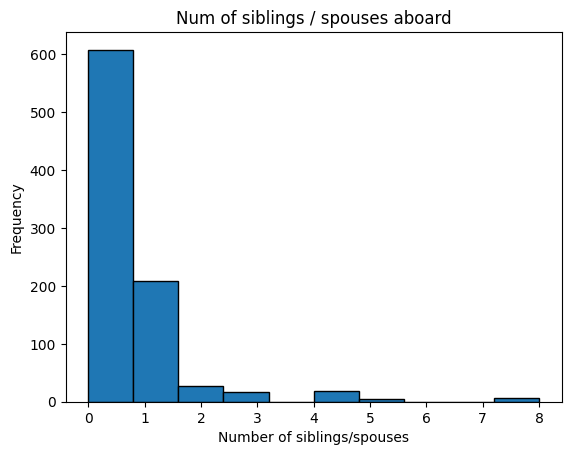

In [43]:
sibsp_data_has_nans = np.isnan(train_data["SibSp"]).any()
print ("SibSp data has nan values:", sibsp_data_has_nans)
sibsp_data_are_all_whole_numbers = all(isinstance(val, int) or (isinstance(val, float) and val.is_integer()) for val in train_data["SibSp"])
print ("SibSp data are all whole numbers:", sibsp_data_are_all_whole_numbers)

plt.hist(train_data["SibSp"], bins=10, edgecolor='black')
plt.title('Num of siblings / spouses aboard')
plt.xlabel('Number of siblings/spouses')
plt.ylabel('Frequency')
plt.show()

Parch data has nan values: False
Parch data are all whole numbers: True


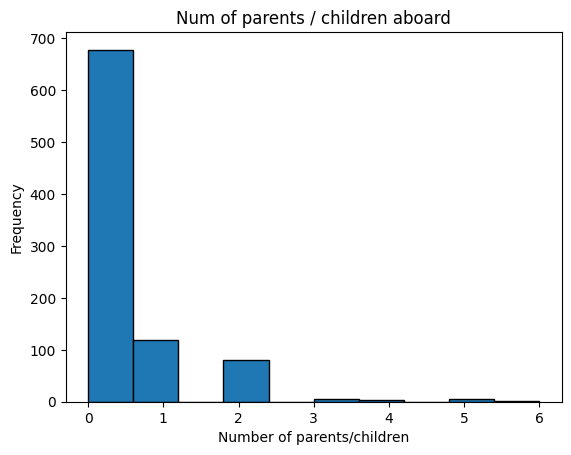

In [44]:
parch_data_has_nans = np.isnan(train_data["Parch"]).any()
print ("Parch data has nan values:", parch_data_has_nans)
parch_data_are_all_whole_numbers = all(isinstance(val, int) or (isinstance(val, float) and val.is_integer()) for val in train_data["Parch"])
print ("Parch data are all whole numbers:", parch_data_are_all_whole_numbers)

plt.hist(train_data["Parch"], bins=10, edgecolor='black')
plt.title('Num of parents / children aboard')
plt.xlabel('Number of parents/children')
plt.ylabel('Frequency')
plt.show()

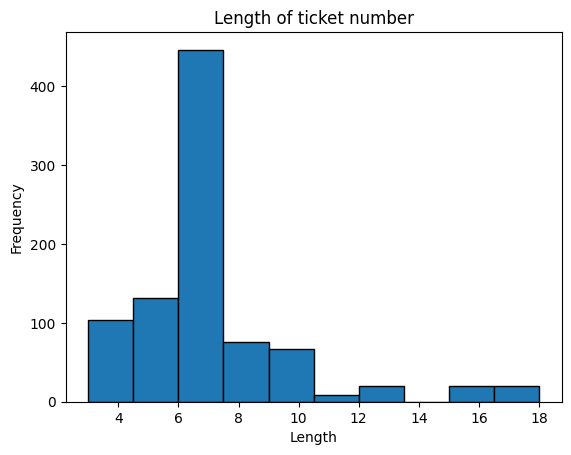

count        891
unique       681
top       347082
freq           7
Name: Ticket, dtype: object

In [31]:
ticket_data_lens = [len(element) for element in train_data["Ticket"]]
plt.hist(ticket_data_lens, bins=10, edgecolor='black')
plt.title('Length of ticket number')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

train_data["Ticket"].describe()

The ticket numbers are quite odd.  They vary in length quite a bit, as shown in the histogram above.  Also many passengers share the same ticket number (681 unique numbers out of 891 total).  It's unclear what advantage this data may offer to the analysis.  It's possible that passengers with the same ticket number may be staying in the same cabin as one another, but this is unclear.  

Fare data has nan values: False


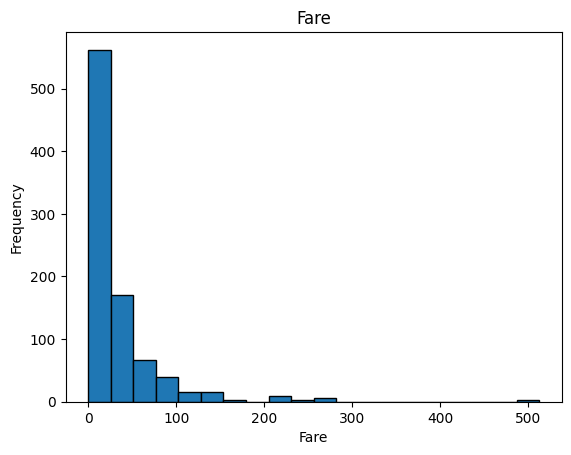

In [42]:
fare_data_has_nans = np.isnan(train_data["Fare"]).any()
print ("Fare data has nan values:", fare_data_has_nans)

plt.hist(train_data["Fare"], bins=20, edgecolor='black')
plt.title('Fare')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.show()

"Cabin" data: According to the info printed near the top of this notebook, 204 out of 891 (or 22.90%) entries are non-null, meaning that a large majority of passengers do not have cabin data in this data set.  

"Embarked" data: According to the info printed near the top of this notebook, 889 out of 891 entries are non-null, so we have this data for all passengers except 2.

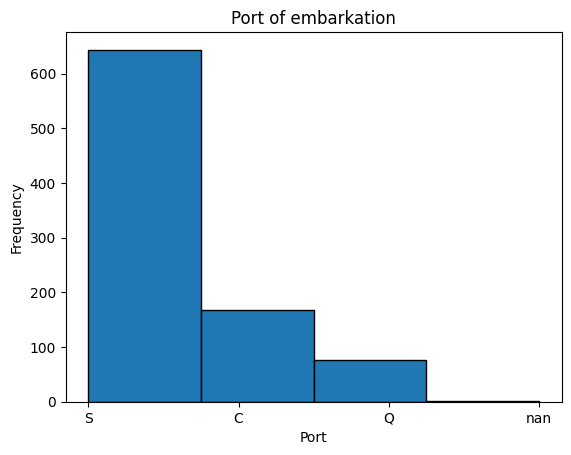

In [41]:
plt.hist([value for value in train_data["Embarked"] if value is not None], bins=4, edgecolor='black')
plt.title('Port of embarkation')
plt.xlabel('Port')
plt.ylabel('Frequency')
plt.show()

A large majority of passengers embarked from port "S" = Southampton, some embarked from port "C" = Cherbourg, and a small minority embarked from port "Q" = Queenstown.  

## Part 3: Data Cleanup <a class="anchor" id="part-3"></a>

Based on the EDA performed above, we can perform some cleanup.
* Fill in the 19.87% of passengers that have no age data with a meaningful default
* Fill in the 2 passengers that have no embarkation port with a meaningful default
* Combine sibling data with parent/child data to reduce the overall number of features
* Transform categorical variables into numerical values, including gender (male/female) and embarkation (C,Q,S)

In [23]:
# Fill in blank age data with random values using the mean and the standard deviation
age_mean = train_data["Age"].mean()
age_std = train_data["Age"].std()
is_null = train_data["Age"].isnull()
num_null_values = is_null.sum()
rand_age = np.random.randint(age_mean - age_std, age_mean + age_std, size=num_null_values)
train_data_with_age_fixes = train_data.copy()
train_data_with_age_fixes.loc[is_null, "Age"] = rand_age

# Also fill in blank embarkation data using the mode
train_data_with_embarkation_fixes = train_data_with_age_fixes.copy()
embarked_mode = train_data_with_embarkation_fixes["Embarked"].mode()[0]
train_data_with_embarkation_fixes.fillna({"Embarked": embarked_mode}, inplace=True)

# Combine sibling and parent data into one feature, then delete the sibling and parent columns
train_data_with_relatives = train_data_with_embarkation_fixes.copy()
train_data_with_relatives["Relatives"] = train_data_with_relatives["SibSp"] + train_data_with_relatives["Parch"]
train_data_with_relatives.drop(['SibSp', 'Parch'], axis=1, inplace=True)

# Update "sex" column to a binary variable in a new column called "sex_male" that is 1 if the passenger is male and 0 if female, then delete the original "sex" column.
train_data_with_sex_female = train_data_with_relatives.copy()
train_data_with_sex_female['Sex_Male'] = (train_data_with_sex_female['Sex'] == 'male').astype(int)
train_data_with_sex_female.drop(['Sex'], axis=1, inplace=True)

# Create 3 new columns for the embarked values of 'C', 'Q', and 'S', then delete the original 'Embarked' column.
train_data_with_embarkation_columns = train_data_with_sex_female.copy()
train_data_with_embarkation_columns['Embarked_C'] = (train_data_with_embarkation_columns['Embarked'] == 'C').astype(int)
train_data_with_embarkation_columns['Embarked_Q'] = (train_data_with_embarkation_columns['Embarked'] == 'Q').astype(int)
train_data_with_embarkation_columns['Embarked_S'] = (train_data_with_embarkation_columns['Embarked'] == 'S').astype(int)
train_data_with_embarkation_columns.drop(['Embarked'], axis=1, inplace=True)

train_data_clean = train_data_with_embarkation_columns.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Age          891 non-null    float64
 5   Ticket       891 non-null    object 
 6   Fare         891 non-null    float64
 7   Cabin        204 non-null    object 
 8   Relatives    891 non-null    int64  
 9   Sex_Male     891 non-null    int64  
 10  Embarked_C   891 non-null    int64  
 11  Embarked_Q   891 non-null    int64  
 12  Embarked_S   891 non-null    int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 90.6+ KB


Now that the data has been cleaned, let's normalize the numerical data using Standard Scaler.

In [25]:
from sklearn.preprocessing import StandardScaler

train_numerical_features = list(train_data_clean.select_dtypes(include=['int64', 'float64']).columns)
standard_scaler = StandardScaler()
train_data_scaled = train_data_clean.copy()
train_data_scaled[train_numerical_features] = standard_scaler.fit_transform(train_data_scaled[train_numerical_features])

,PassengerId,Survived,Pclass,Age,Fare,Relatives,Sex_Male,Embarked_C,Embarked_Q,Embarked_S
count,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,891.000000,8.910000e+02
mean,6.379733e-17,3.987333e-17,-8.772133e-17,1.993666e-17,3.987333e-18,-3.987333e-18,-1.156327e-16,-1.993666e-17,0.000000,-8.373399e-17
std,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562,1.000562e+00
min,-1.730108e+00,-7.892723e-01,-1.566107e+00,-2.145957e+00,-6.484217e-01,-5.609748e-01,-1.355574e+00,-4.820427e-01,-0.307562,-1.623803e+00
25%,-8.650540e-01,-7.892723e-01,-3.693648e-01,-6.312714e-01,-4.891482e-01,-5.609748e-01,-1.355574e+00,-4.820427e-01,-0.307562,-1.623803e+00
50%,0.000000e+00,-7.892723e-01,8.273772e-01,-1.160722e-01,-3.573909e-01,-5.609748e-01,7.376951e-01,-4.820427e-01,-0.307562,6.158384e-01
75%,8.650540e-01,1.266990e+00,8.273772e-01,6.199267e-01,-2.424635e-02,5.915988e-02,7.376951e-01,-4.820427e-01,-0.307562,6.158384e-01
max,1.730108e+00,1.266990e+00,8.273772e-01,3.711122e+00,9.667167e+00,5.640372e+00,7.376951e-01,2.074505e+00,3.251373,6.158384e-01


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X, y = train_data_scaled.drop(["Survived", "Name", "Ticket", "Cabin"], axis=1), train_data_scaled["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10) 
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg_predictions = log_reg.predict(X_test)

log_reg_data = test_data.copy()
log_reg_data.insert((log_reg_data.shape[1]),'Survived', log_reg_predictions)
log_reg_data.to_csv('log_reg.csv')

ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.